In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mobile-price-classification/train.csv
/kaggle/input/mobile-price-classification/test.csv


In [2]:
train_df = pd.read_csv("/kaggle/input/mobile-price-classification/train.csv")
train_df.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1


In [3]:
train_df.shape

(2000, 21)

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   battery_power  2000 non-null   int64  
 1   blue           2000 non-null   int64  
 2   clock_speed    2000 non-null   float64
 3   dual_sim       2000 non-null   int64  
 4   fc             2000 non-null   int64  
 5   four_g         2000 non-null   int64  
 6   int_memory     2000 non-null   int64  
 7   m_dep          2000 non-null   float64
 8   mobile_wt      2000 non-null   int64  
 9   n_cores        2000 non-null   int64  
 10  pc             2000 non-null   int64  
 11  px_height      2000 non-null   int64  
 12  px_width       2000 non-null   int64  
 13  ram            2000 non-null   int64  
 14  sc_h           2000 non-null   int64  
 15  sc_w           2000 non-null   int64  
 16  talk_time      2000 non-null   int64  
 17  three_g        2000 non-null   int64  
 18  touch_sc

In [5]:
train_df.duplicated().sum()

0

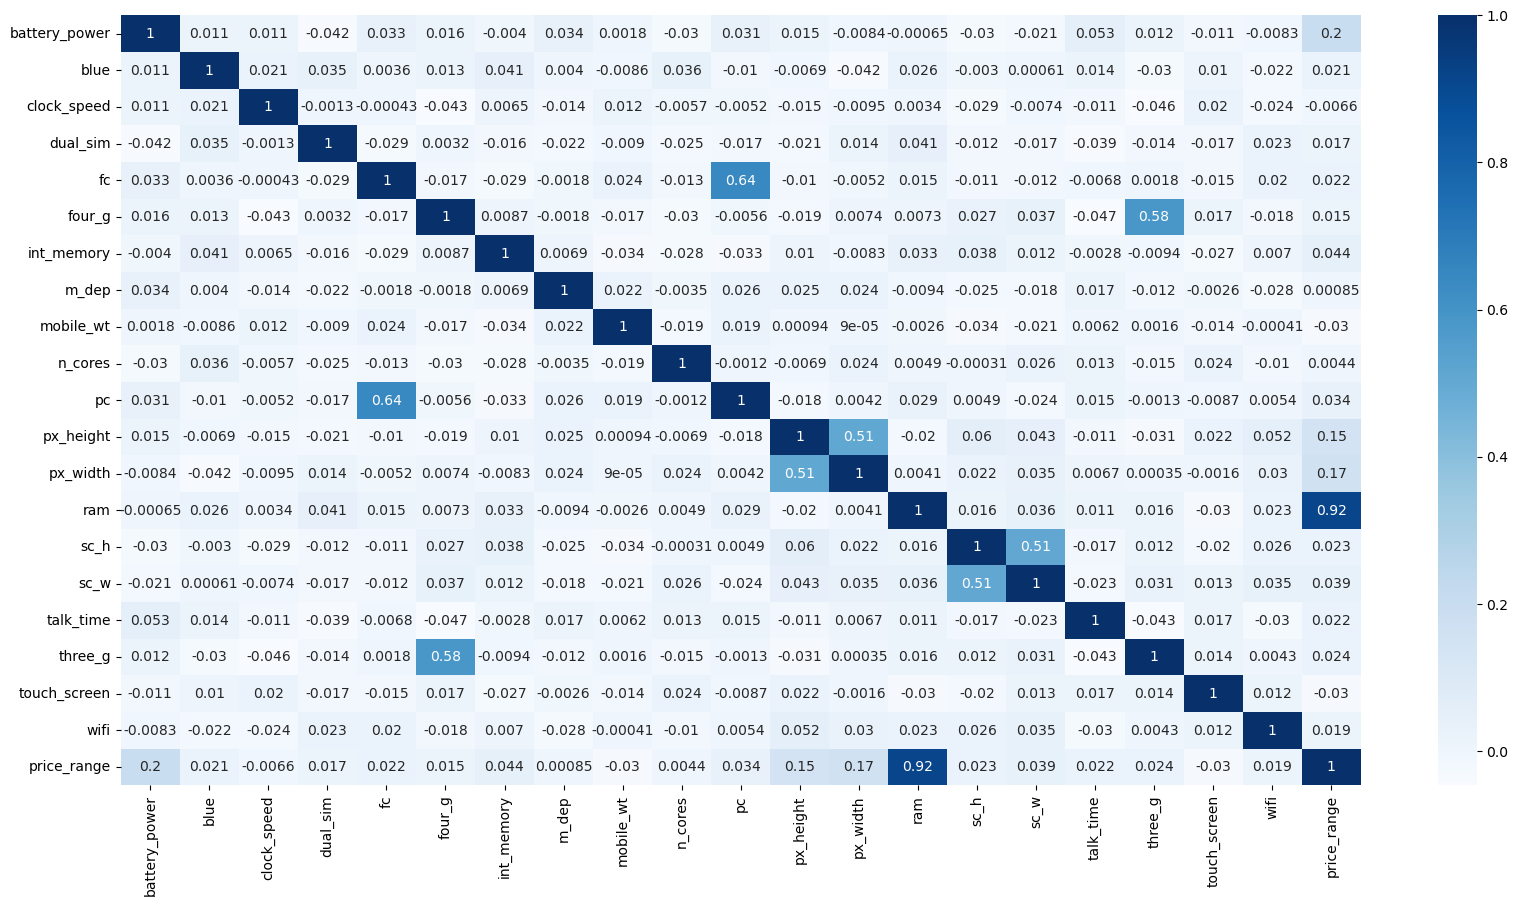

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(20,10))
sns.heatmap(train_df.corr(),annot = True,cmap = 'Blues')
plt.show()

**Let's combine px_height and px_width to single feature called res.**

In [7]:
train_df["res"] = train_df["px_height"] * train_df["px_width"]
train_df.drop(["px_height","px_width"], axis=1, inplace=True)
train_df.shape

(2000, 20)

In [8]:
train_df.corr()["price_range"].drop("price_range").sort_values(ascending=False)

ram              0.917046
battery_power    0.200723
res              0.176240
int_memory       0.044435
sc_w             0.038711
pc               0.033599
three_g          0.023611
sc_h             0.022986
fc               0.021998
talk_time        0.021859
blue             0.020573
wifi             0.018785
dual_sim         0.017444
four_g           0.014772
n_cores          0.004399
m_dep            0.000853
clock_speed     -0.006606
mobile_wt       -0.030302
touch_screen    -0.030411
Name: price_range, dtype: float64

**Let's create validation data**

In [9]:
X = train_df.drop("price_range", axis = 1)
y = train_df["price_range"]
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((1600, 19), (400, 19), (1600,), (400,))

In [10]:
from sklearn.preprocessing import MinMaxScaler
mmscaler = MinMaxScaler()
X_train = mmscaler.fit_transform(X_train)
X_val = mmscaler.transform(X_val)

In [11]:
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

random_forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
gradient_boosting_clf = GradientBoostingClassifier(random_state=42)
logistic_regression_clf = LogisticRegression(random_state=42)

In [12]:
estimators = [random_forest_clf, gradient_boosting_clf, logistic_regression_clf]
for estimator in estimators:
    print("Training the", estimator)
    estimator.fit(X_train, y_train)

Training the RandomForestClassifier(random_state=42)
Training the GradientBoostingClassifier(random_state=42)
Training the LogisticRegression(random_state=42)


In [13]:
[estimator.score(X_val, y_val) for estimator in estimators]

[0.885, 0.8925, 0.9]

In [14]:
voting_clf = VotingClassifier(
    estimators=[
        ('rf', random_forest_clf),
        ('gb', gradient_boosting_clf),
        ('lr', logistic_regression_clf)
    ],
    voting='soft'
)

voting_clf.fit(X_train, y_train)

voting_clf.score(X_val, y_val)

0.8975

**It's a little bit worse than the best estimator, let's try the hard voting.**

In [15]:
voting_clf.voting = "hard"
voting_clf.score(X_val, y_val)

0.8975

**Let's train XGBoost now.**

In [16]:
import xgboost
xgb_clf = xgboost.XGBClassifier(random_state=42)
xgb_clf.fit(X_train, y_train,
                eval_set=[(X_val, y_val)], early_stopping_rounds=2, verbose=0)
xgb_clf.score(X_val, y_val)           

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


0.895

In [17]:
from sklearn.metrics import confusion_matrix, classification_report
y_pred_voting_clf = voting_clf.predict(X_val)
print(confusion_matrix(y_val, y_pred_voting_clf))

[[101   4   0   0]
 [  8  78   5   0]
 [  0   7  78   7]
 [  0   0  10 102]]


In [18]:
print(classification_report(y_val, y_pred_voting_clf))

              precision    recall  f1-score   support

           0       0.93      0.96      0.94       105
           1       0.88      0.86      0.87        91
           2       0.84      0.85      0.84        92
           3       0.94      0.91      0.92       112

    accuracy                           0.90       400
   macro avg       0.89      0.89      0.89       400
weighted avg       0.90      0.90      0.90       400



In [19]:
y_pred_xgb_clf = xgb_clf.predict(X_val)
print(confusion_matrix(y_val, y_pred_xgb_clf))

[[98  7  0  0]
 [ 5 82  4  0]
 [ 0  8 79  5]
 [ 0  0 13 99]]


In [20]:
print(classification_report(y_val, y_pred_xgb_clf))

              precision    recall  f1-score   support

           0       0.95      0.93      0.94       105
           1       0.85      0.90      0.87        91
           2       0.82      0.86      0.84        92
           3       0.95      0.88      0.92       112

    accuracy                           0.90       400
   macro avg       0.89      0.89      0.89       400
weighted avg       0.90      0.90      0.90       400

